In [1]:
import os
from utils import Portfolio
import pandas as pd
import numpy as np

os.chdir('C:/Users/howar/Desktop/Coursework/ME4-Individual-Project-Volatility-Forecasting')
os.environ['R_HOME'] = 'C:/Program Files/R/R-4.1.2'

In [3]:
r = pd.read_csv('data/daily_returns.csv', index_col=0, parse_dates=True)
intraday = pd.read_csv('data/intraday_returns.csv', index_col=0, parse_dates=True)

# Match dates
r = r[r.index.isin(np.unique(intraday.index.date))]

In [4]:
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import pandas2ri
import rpy2.robjects as ro 
from tqdm.notebook import trange

with localconverter(ro.default_converter + pandas2ri.converter):
    r_rets = ro.conversion.py2rpy(r)

r_ccc_code = """
    library('rmgarch')
    function(r_rets, window_size){
            univariate_spec <- ugarchspec(mean.model = list(armaOrder = c(0,0)),
                                          variance.model = list(garchOrder = c(1,1),
                                          variance.targeting = FALSE, 
                                          model = "sGARCH"),
                                          distribution.model = "norm") 
            n <- dim(r_rets)[2]
            dcc_spec <- dccspec(uspec = multispec(replicate(n, univariate_spec)), dccOrder = c(1,1),
                                distribution = "mvnorm")        
            forecasts <- dccroll(dcc_spec, r_rets, n.ahead=1, forecast.length=dim(r_rets)[1]-window_size,
                                 refit.window="moving")
            return(rcov(forecasts))
    }
    """

window = 252
r_cccgarch = ro.r(r_ccc_code)
covariance = np.array(r_cccgarch(r_rets, window)).T

R[write to console]: Loading required package: rugarch

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: 'rugarch'


R[write to console]: The following object is masked from 'package:stats':

    sigma




Final Portfolio Value: $118.5
Overall Return (%): 18.49
Sharpe Ratio: 1.69
Sortino Ratio: 2.2


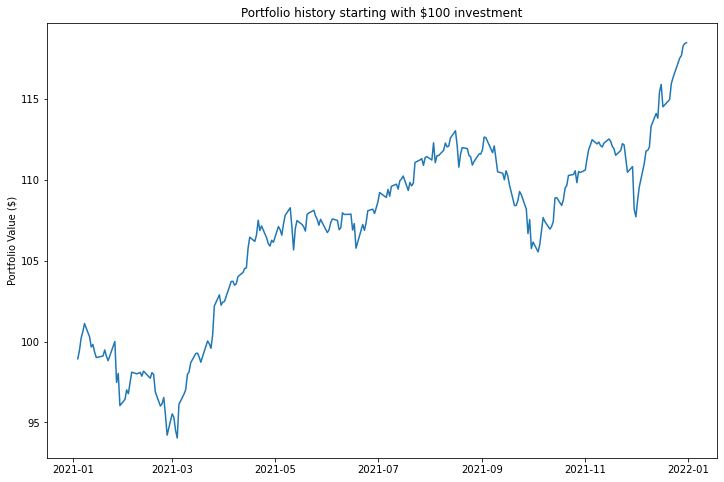

In [5]:
r_test = pd.read_csv('data/daily_returns_test.csv', index_col=0, parse_dates=True)
test_window = len(r_test)

dcc_port = Portfolio(r_test, covariance[-test_window:])
dcc_returns = dcc_port.optimize(return_percent=True)

# Optimization results
dcc_port.metrics(starting_value=100, print_metrics=True, plot_history=True)

In [6]:
os.chdir('C:/Users/howar/Desktop/Coursework/ME4-Individual-Project-Volatility-Forecasting')
np.save('outputs/DCC/covariance.npy', covariance)
dcc_port.weights.to_csv('outputs/DCC/portfolio_weights.csv', index=True)